In [130]:
import uproot
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import sys, os

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm
from matplotlib.collections import LineCollection
from matplotlib import cm

## Define Function for Invariant Mass

In [73]:
def M(pt1,eta1,phi1,m1,pt2,eta2,phi2,m2):
    px1, py1, pz1 = pt1*np.cos(phi1), pt1*np.sin(phi1), np.sqrt(m1**2+pt1**2)*np.sinh(eta1)
    e1 = np.sqrt(m1**2 + px1**2 + py1**2 + pz1**2)
    px2, py2, pz2 = pt2*np.cos(phi2), pt2*np.sin(phi2), np.sqrt(m2**2+pt2**2)*np.sinh(eta2)
    e2 = np.sqrt(m2**2 + px2**2 + py2**2 + pz2**2)
    
    return np.sqrt((e1+e2)**2-(px1+px2)**2-(py1+py2)**2-(pz1+pz2)**2)
    

## Fill particle information in to NumpyArray 

In [65]:
class BrachGenParticles:
    def __init__(self,file):
        self.file = file
        self.Status = file["Particle.Status"].array()
        self.PID = file["Particle.PID"].array()
        self.M1 = file["Particle.M1"].array()
        self.M2 = file["Particle.M2"].array()
        self.D1 = file["Particle.D1"].array()
        self.D2  = file["Particle.D2"].array()
        self.PT = file["Particle.PT"].array()
        self.Eta =  file["Particle.Eta"].array()
        self.Phi = file["Particle.Phi"].array()
        self.Mass = file["Particle.Mass"].array()
        self.Labels = ["Status", "PID" , "M1", "M2", "D1", "D2", "PT", "Eta", "Phi", "Mass"]
        
    def Status_At(self, i):
        return self.Status[i]
    def PID_At(self, i):
        return self.PID[i]
    def M1_At(self, i):
        return self.M1[i]
    def M2_At(self, i):
        return self.M2[i]
    def D1_At(self, i):
        return self.D1[i]
    def D2_At(self, i):
        return self.D2[i]
    def PT_At(self, i):
        return self.PT[i]
    def Eta_At(self, i):
        return self.Eta[i]
    def Phi_At(self, i):
        return self.Phi[i]
    def Mass_At(self, i):
        return self.Mass[i]
    
class BrachJet:
    def __init__(self,file):
        self.file = file
        self.PT = file["Particle.PT"].array()
        self.Eta =  file["Particle.Eta"].array()
        self.Phi = file["Particle.Phi"].array()
        self.Mass = file["Particle.Mass"].array()
        
    def PT_At(self, i):
        return self.PT[i]
    def Eta_At(self, i):
        return self.Eta[i]
    def Phi_At(self, i):
        return self.Phi[i]
    def Mass_At(self, i):
        return self.Mass[i]
    
class Event_Weight:
    def __init__(self,file):
        self.file = file
        self.Event_Weight = file["Event.Weight"].array()
        
    def Event_Weight_At(self, i):
        return self.Event_Weight[i]

In [131]:
def MyFunction(file):
    GenParticle = np.array([file["Particle.Status"].array(),
                            file["Particle.PID"].array(),
                            file["Particle.M1"].array(),
                            file["Particle.M2"].array(),
                            file["Particle.D1"].array(),
                            file["Particle.D2"].array(),
                            file["Particle.PT"].array(),
                            file["Particle.Eta"].array(),
                            file["Particle.Phi"].array(),
                            file["Particle.Mass"].array()])

    Jet = np.array([file["Jet.PT"].array(),
                            file["Jet.Eta"].array(),
                            file["Jet.Phi"].array(),
                            file["Jet.Mass"].array()
                           ])

    Event_Weight = np.array(file["Event.Weight"].array())

    return GenParticle, Jet, Event_Weight


def Preselection(Jet):
    twojet_invariantmass = []
    survived_list = []
    for i in range(len(Jet[0])):
        if len(Jet[0][i]) < 2:
            continue

        if Jet[0][i][0] < 440 or Jet[0][i][1] < 60:
            continue

        if np.abs(Jet[1][i][0]-Jet[1][i][1]) > 1.2:
            continue

        twojet_invariantmass.append(M(Jet[0][i][0],Jet[1][i][0],Jet[2][i][0],Jet[3][i][0],Jet[0][i][1],Jet[1][i][1],Jet[2][i][1],Jet[3][i][1]))

        survived_list.append(i)

    print("There are {} events.".format(len(twojet_invariantmass)))
    
    return np.array(twojet_invariantmass), np.array(survived_list)


def Check_r_inv(GenParticle):
    invis_count, vis_count = 0, 0
    Ndark = 0
    for i in range(len(GenParticle[1])):
        for j in range(len(GenParticle[0][i])):
            PID = GenParticle[1][i][j]
            M1 = GenParticle[2][i][j]
            M2 = GenParticle[3][i][j]
            D1 = GenParticle[4][i][j]
            D2 = GenParticle[5][i][j]
            status = GenParticle[0][i][j]
            
            if (abs(PID) == 4900111) and (abs(GenParticle[1][i][D1]) != 4900111) and (abs(GenParticle[1][i][D2]) != 4900111):
                if (abs(GenParticle[1][i][D1]) != 3) and (abs(GenParticle[1][i][D2]) != 3):
                    invis_count += 1

            if (abs(PID) == 4900111) and (abs(GenParticle[1][i][D1]) != 4900111) and (abs(GenParticle[1][i][D2]) != 4900111):
                if (abs(GenParticle[1][i][D1]) == 3) or (abs(GenParticle[1][i][D2]) == 3):
                    vis_count += 1

            if (abs(PID) == 4900113) and (abs(GenParticle[1][i][D1]) != 4900113) and (abs(GenParticle[1][i][D2]) != 4900113):
                if (abs(GenParticle[1][i][D1]) > 490000) or (abs(GenParticle[1][i][D2]) > 490000):
                    invis_count += 1
#                     print("{:^5}{:^7}{:^7}{:^7}{:^7}{:^7}{:^7}{:^8.5}{:^8.5}{:^8.5}{:^8.5}".format( \
#         j, GenParticle[0][i][j],  GenParticle[1][i][j], GenParticle[2][i][j], GenParticle[3][i][j],
#         GenParticle[4][i][j], GenParticle[5][i][j], GenParticle[6][i][j], GenParticle[7][i][j] ,GenParticle[8][i][j], GenParticle[9][i][j]))




            if (abs(PID) == 4900113) and (abs(GenParticle[1][i][D1]) != 4900113) and (abs(GenParticle[1][i][D2]) != 4900113):
                if (abs(GenParticle[1][i][D1]) < 6) or (abs(GenParticle[1][i][D2]) < 6):
                    vis_count += 1

                    
#             if (abs(PID) == 4900211) and (( abs(GenParticle[1][i][M1])== 4900101) or (abs(GenParticle[1][i][M2]) == 4900101)):
#                     Ndark += 1

#             if (abs(PID) == 4900213) and (( abs(GenParticle[1][i][M1])== 4900101) or (abs(GenParticle[1][i][M2]) == 4900101)):
#                     Ndark += 1
                    
#             if (abs(PID) == 4900111) and (( abs(GenParticle[1][i][M1])== 4900101) or (abs(GenParticle[1][i][M2]) == 4900101)):
#                     Ndark += 1
                    
#             if (abs(PID) == 4900113) and (( abs(GenParticle[1][i][M1])== 4900101) or (abs(GenParticle[1][i][M2]) == 4900101)):
#                     Ndark += 1

            if (abs(PID) == 4900211) and (status == 1):
                    Ndark += 1

            if (abs(PID) == 4900213) and (status == 1):
                    Ndark += 1
                    
                    
    print("There are {} events.".format(len(GenParticle[0])))
    print("There are Dark meson {}  decay into invisible particle.".format(invis_count))
    print("There are Dark meson {}  decay into visible particle.".format(vis_count))
    print("r_inv = {:^4.4f} ".format(invis_count/(invis_count+vis_count)))
    
    print("There are {} stable Dark mesons.".format(Ndark))
    print("Average = {:^4.4f} ".format(Ndark/len(GenParticle[0])))
    return invis_count/(invis_count+vis_count), Ndark/len(GenParticle[0])


def Find_xdxd(GenParticle):
    m_xdxd = []
    for i in range(len(GenParticle[1])):
        for j in range(len(GenParticle[0][i])):
            PID = GenParticle[1][i][j]
            M1 = GenParticle[2][i][j]
            M2 = GenParticle[3][i][j]
            D1 = GenParticle[4][i][j]
            D2 = GenParticle[5][i][j]
            status = GenParticle[0][i][j]
            
            if PID == 4900101:
                tmp_1_pt = GenParticle[6][i][j]
                tmp_1_eta = GenParticle[7][i][j]
                tmp_1_phi = GenParticle[8][i][j]
                tmp_1_m = GenParticle[9][i][j]
#                 print(tmp_1_pt,tmp_1_eta,tmp_1_phi,tmp_1_m)
                break
                
        for j in range(len(GenParticle[0][i])):
            PID = GenParticle[1][i][j]
            M1 = GenParticle[2][i][j]
            M2 = GenParticle[3][i][j]
            D1 = GenParticle[4][i][j]
            D2 = GenParticle[5][i][j]
            status = GenParticle[0][i][j]

            if PID == -4900101:
                tmp_2_pt = GenParticle[6][i][j]
                tmp_2_eta = GenParticle[7][i][j]
                tmp_2_phi = GenParticle[8][i][j]
                tmp_2_m = GenParticle[9][i][j]
#                 print(tmp_2_pt,tmp_2_eta,tmp_2_phi,tmp_2_m)
                break
                
                
        m_xdxd.append(M(tmp_1_pt,tmp_1_eta,tmp_1_phi,tmp_1_m,tmp_2_pt,tmp_2_eta,tmp_2_phi,tmp_2_m))
        
    return np.array(m_xdxd)
    

## Import File

In [186]:
# path = "/home/Storage/MG5_Study_Group/ROOT/Scan_rinv_alpha_md5"
path = "/home/Storage/MG5_Study_Group/ROOT/from_my_10"
filepath_0_10 = path + "/SVJ_0_10.root"
filepath_03_10 = path + "/SVJ_3_10.root"
# filepath_05_10 = path + "/SVJ_5_10.root"
filepath_09_10 = path + "/SVJ_9_10.root"
filepath_03_100 = path + "/SVJ_3_100.root"
# filepath_05_100 = path + "/SVJ_5_100.root"
filepath_09_100 = path + "/SVJ_9_100.root"
filepath_03_300 = path + "/SVJ_3_300.root"
# filepath_05_300 = path + "/SVJ_5_300.root"
filepath_09_300 = path + "/SVJ_9_300.root"

file_0_10 = uproot.open(filepath_0_10)["Delphes;1"]
file_03_10 = uproot.open(filepath_03_10)["Delphes;1"]
# file_05_10 = uproot.open(filepath_05_10)["Delphes;1"]
file_09_10 = uproot.open(filepath_09_10)["Delphes;1"]
file_03_100 = uproot.open(filepath_03_100)["Delphes;1"]
# file_05_100 = uproot.open(filepath_05_100)["Delphes;1"]
file_09_100 = uproot.open(filepath_09_100)["Delphes;1"]
file_03_300 = uproot.open(filepath_03_300)["Delphes;1"]
# file_05_300 = uproot.open(filepath_05_300)["Delphes;1"]
file_09_300 = uproot.open(filepath_09_300)["Delphes;1"]

In [187]:
# file_0.show()

In [189]:
GenParticle_0_10, Jet_0_10, Event_Weight_0_10 = MyFunction(file_0_10)
GenParticle_03_10, Jet_03_10, Event_Weight_03_10 = MyFunction(file_03_10)
# GenParticle_05_10, Jet_05_10, Event_Weight_05_10 = MyFunction(file_05_10)
GenParticle_09_10, Jet_09_10, Event_Weight_09_10 = MyFunction(file_09_10)

GenParticle_03_100, Jet_03_100, Event_Weight_03_100 = MyFunction(file_03_100)
# GenParticle_05_100, Jet_05_100, Event_Weight_05_100 = MyFunction(file_05_100)
GenParticle_09_100, Jet_09_100, Event_Weight_09_100 = MyFunction(file_09_100)

GenParticle_03_300, Jet_03_300, Event_Weight_03_300 = MyFunction(file_03_300)
# GenParticle_05_300, Jet_05_300, Event_Weight_05_300 = MyFunction(file_05_300)
GenParticle_09_300, Jet_09_300, Event_Weight_09_300 = MyFunction(file_09_300)

# Check the Event Shape

In [ ]:
np.array(GenParticle_05_300).shape

## Check the $r_{inv}$

In [194]:
Check_r_inv(GenParticle_0_10)
Check_r_inv(GenParticle_03_10)
# Check_r_inv(GenParticle_05_10)
Check_r_inv(GenParticle_09_10)
Check_r_inv(GenParticle_03_100)
# Check_r_inv(GenParticle_05_100)
Check_r_inv(GenParticle_09_100)
Check_r_inv(GenParticle_03_300)
# Check_r_inv(GenParticle_05_300)
Check_r_inv(GenParticle_09_300)

There are 16419 events.
There are Dark meson 0  decay into invisible particle.
There are Dark meson 89768  decay into visible particle.
r_inv = 0.0000 
There are 91190 stable Dark mesons.
Average = 5.5539 
There are 16365 events.
There are Dark meson 26953  decay into invisible particle.
There are Dark meson 62727  decay into visible particle.
r_inv = 0.3005 
There are 144888 stable Dark mesons.
Average = 8.8535 
There are 16472 events.
There are Dark meson 81347  decay into invisible particle.
There are Dark meson 8941  decay into visible particle.
r_inv = 0.9010 
There are 254902 stable Dark mesons.
Average = 15.4749 
There are 16387 events.
There are Dark meson 23284  decay into invisible particle.
There are Dark meson 54614  decay into visible particle.
r_inv = 0.2989 
There are 128504 stable Dark mesons.
Average = 7.8418 
There are 16370 events.
There are Dark meson 69925  decay into invisible particle.
There are Dark meson 7697  decay into visible particle.
r_inv = 0.9008 
There 

(0.901320554967404, 9.459623927463031)

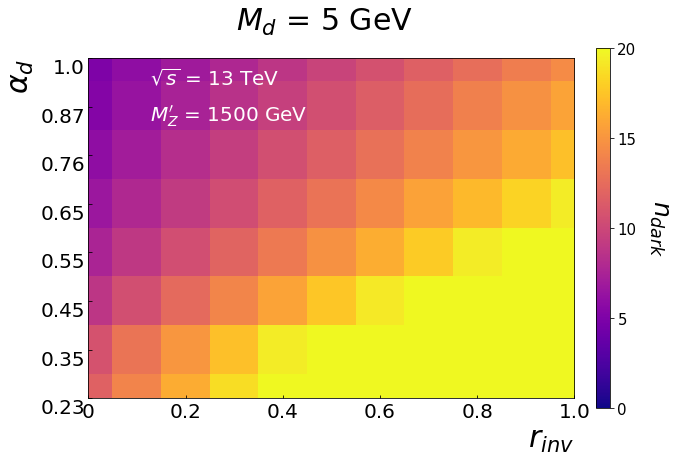

In [158]:
ndark_5 = np.load("./ndark_mdq5.npy")
# ndark_5 = ndark_5/2

# ndark_10 = np.load("./ndark_mdq10_mz1000.npy")
# print(ndark.shape)
# print(ndark)

fig, ax = plt.subplots(1,1, figsize=(10,10))
plt.imshow(ndark_5,cmap="plasma",vmin=0, vmax=20,origin='lower')
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)

cax = plt.axes([0.83, 0.25, 0.02, 0.5])
cbar = plt.colorbar(cax=cax)  
cbar.ax.tick_params(labelsize=15)
cbar.ax.yaxis.set_major_locator(MaxNLocator(4))
cbar.set_label("$n_{dark}$", rotation=270, fontsize=25, labelpad=35, y=0.5)

ax.set_ylabel("$\\alpha_d$", fontsize=30, horizontalalignment='right',y=1)
ax.set_yticks([0,1,2,3,4,5,6,7,8])
ax.set_yticklabels(["0.23","0.35","0.45","0.55","0.65","0.76","0.87","1.0"], fontsize=25, rotation=0, verticalalignment='top', horizontalalignment="right")

ax.set_xticks([0,2,4,6,8,10])
ax.set_xticklabels(["0","0.2","0.4","0.6","0.8","1.0"], fontsize=25, rotation=0, verticalalignment='top', horizontalalignment="center")
ax.set_xlabel("$r_{inv}$", fontsize=30,horizontalalignment='right',x=1)

ax.tick_params(axis='x', direction="in", labelsize=20)
ax.tick_params(axis='y', direction="in", labelsize=20)

plt.text(x=-500,y=21, s="$M_d$ = 5 GeV", rotation=0 ,fontsize=30)
plt.text(x=-620,y=18, s="$\sqrt{s}$ = 13 TeV", rotation=0 ,fontsize=20, c="w")
plt.text(x=-620,y=16, s="$M_Z'$ = 1500 GeV", rotation=0 ,fontsize=20, c="w")
        
ax.set_xlim((0,10))
ax.set_ylim((0,7))
plt.subplots_adjust(wspace=0.1, hspace=0.1)
# plt.savefig("./ndark_10.pdf", transparent=True)
plt.show()



## Ndark $M_d$ = 10 GeV 

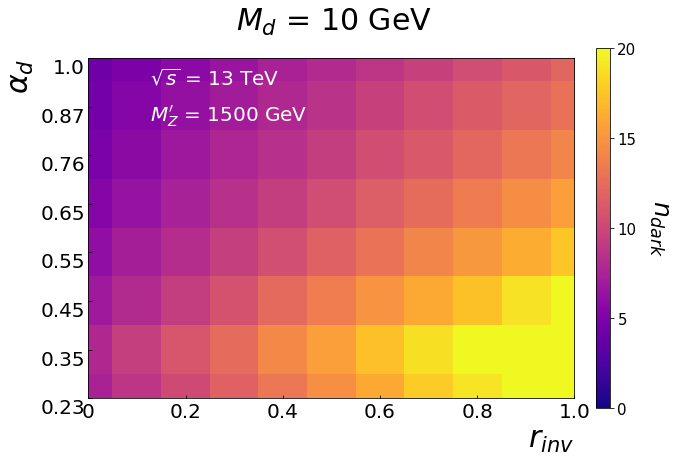

In [167]:
ndark_10 = np.load("./ndark_mdq10.npy")
# ndark_10 = ndark_10/2
# ndark_10 = np.load("./ndark_mdq10_mz1000.npy")
# print(ndark.shape)
# print(ndark)

fig, ax = plt.subplots(1,1, figsize=(10,10))
plt.imshow(ndark_10,cmap="plasma",vmin=0, vmax=20,origin='lower')
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)

cax = plt.axes([0.83, 0.25, 0.02, 0.5])
cbar = plt.colorbar(cax=cax)  
cbar.ax.tick_params(labelsize=15)
cbar.ax.yaxis.set_major_locator(MaxNLocator(4))
cbar.set_label("$n_{dark}$", rotation=270, fontsize=25, labelpad=35, y=0.5)

ax.set_ylabel("$\\alpha_d$", fontsize=30, horizontalalignment='right',y=1)
ax.set_yticks([0,1,2,3,4,5,6,7,8])
ax.set_yticklabels(["0.23","0.35","0.45","0.55","0.65","0.76","0.87","1.0"], fontsize=25, rotation=0, verticalalignment='top', horizontalalignment="right")

ax.set_xticks([0,2,4,6,8,10])
ax.set_xticklabels(["0","0.2","0.4","0.6","0.8","1.0"], fontsize=25, rotation=0, verticalalignment='top', horizontalalignment="center")
ax.set_xlabel("$r_{inv}$", fontsize=30,horizontalalignment='right',x=1)

ax.tick_params(axis='x', direction="in", labelsize=20)
ax.tick_params(axis='y', direction="in", labelsize=20)

plt.text(x=-500,y=21, s="$M_d$ = 10 GeV", rotation=0 ,fontsize=30)
plt.text(x=-620,y=18, s="$\sqrt{s}$ = 13 TeV", rotation=0 ,fontsize=20, c="w")
plt.text(x=-620,y=16, s="$M_Z'$ = 1500 GeV", rotation=0 ,fontsize=20, c="w")
        
ax.set_xlim((0,10))
ax.set_ylim((0,7))
plt.subplots_adjust(wspace=0.1, hspace=0.1)
# plt.savefig("./ndark_10.pdf", transparent=True)
plt.show()


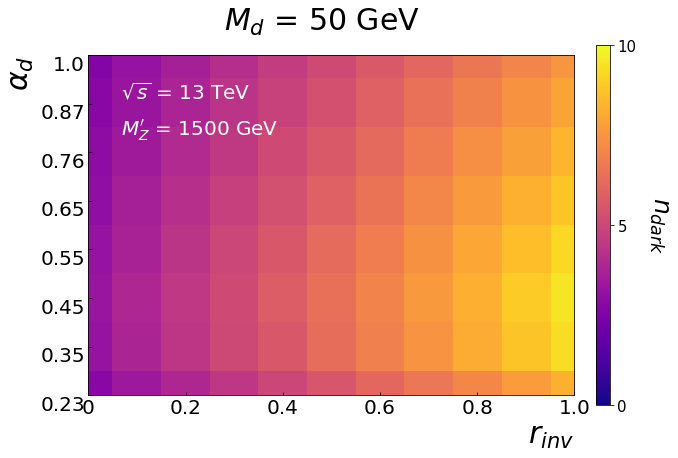

In [160]:
ndark_50 = np.load("./ndark_mdq50.npy")
# ndark_50 = ndark_50/2
# ndark_10 = np.load("./ndark_mdq10_mz1000.npy")
# print(ndark.shape)
# print(ndark)


fig, ax = plt.subplots(1,1, figsize=(10,10))

ax2 = plt.subplot(1,1,1)
plt.imshow(ndark_50,cmap="plasma",vmin=0, vmax=10,origin='lower')


ax2.set_ylabel("$\\alpha_d$", fontsize=30, horizontalalignment='right',y=1)
ax2.set_yticks([0,1,2,3,4,5,6,7,8])
ax2.set_yticklabels(["0.23","0.35","0.45","0.55","0.65","0.76","0.87","1.0"], fontsize=25, rotation=0, verticalalignment='top', horizontalalignment="right")

ax2.set_xticks([0,2,4,6,8,10])
ax2.set_xticklabels(["0","0.2","0.4","0.6","0.8","1.0"], fontsize=25, rotation=0, verticalalignment='top', horizontalalignment="center")
ax2.set_xlabel("$r_{inv}$", fontsize=30,horizontalalignment='right',x=1)

ax2.tick_params(axis='x', direction="in", labelsize=20)
ax2.tick_params(axis='y', direction="in", labelsize=20)
ax2.set_xlim((0,10))
ax2.set_ylim((0,7))


ax2.text(x=2.8,y=7.5, s="$M_d$ = 50 GeV", rotation=0 ,fontsize=30)

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.83, 0.25, 0.02, 0.5])
cbar = plt.colorbar(cax=cax)  
cbar.ax.tick_params(labelsize=15)
cbar.ax.yaxis.set_major_locator(MaxNLocator(2))
cbar.set_label("$n_{dark}$", rotation=270, fontsize=25, labelpad=35, y=0.5)



plt.text(x=-330,y=8.5, s="$\sqrt{s}$ = 13 TeV", rotation=0 ,fontsize=20, c="w")
plt.text(x=-330,y=7.5, s="$M_Z'$ = 1500 GeV", rotation=0 ,fontsize=20, c="w")
        

plt.subplots_adjust(wspace=0.1, hspace=0.1)
# plt.savefig("./ndark_100.pdf", transparent=True)
plt.show()






## Ndark $M_d$ = 100 GeV 

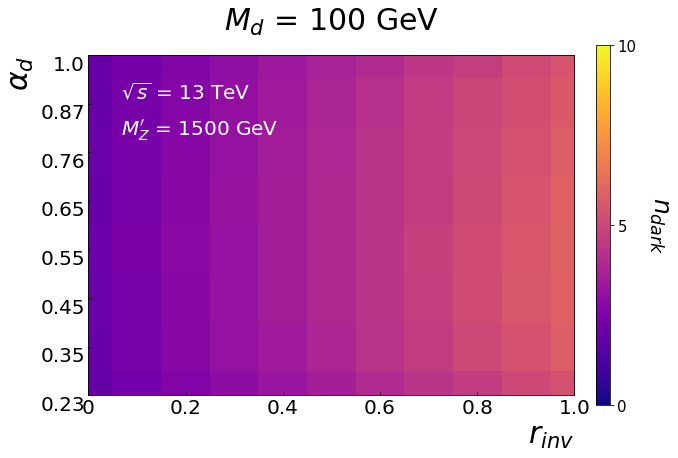

In [168]:
ndark_100 = np.load("./ndark_mdq100.npy")
# ndark_100 = ndark_100/2
fig, ax = plt.subplots(1,1, figsize=(10,10))

ax2 = plt.subplot(1,1,1)
plt.imshow(ndark_100,cmap="plasma",vmin=0, vmax=10,origin='lower')


ax2.set_ylabel("$\\alpha_d$", fontsize=30, horizontalalignment='right',y=1)
ax2.set_yticks([0,1,2,3,4,5,6,7,8])
ax2.set_yticklabels(["0.23","0.35","0.45","0.55","0.65","0.76","0.87","1.0"], fontsize=25, rotation=0, verticalalignment='top', horizontalalignment="right")

ax2.set_xticks([0,2,4,6,8,10])
ax2.set_xticklabels(["0","0.2","0.4","0.6","0.8","1.0"], fontsize=25, rotation=0, verticalalignment='top', horizontalalignment="center")
ax2.set_xlabel("$r_{inv}$", fontsize=30,horizontalalignment='right',x=1)

ax2.tick_params(axis='x', direction="in", labelsize=20)
ax2.tick_params(axis='y', direction="in", labelsize=20)
ax2.set_xlim((0,10))
ax2.set_ylim((0,7))


ax2.text(x=2.8,y=7.5, s="$M_d$ = 100 GeV", rotation=0 ,fontsize=30)

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.83, 0.25, 0.02, 0.5])
cbar = plt.colorbar(cax=cax)  
cbar.ax.tick_params(labelsize=15)
cbar.ax.yaxis.set_major_locator(MaxNLocator(2))
cbar.set_label("$n_{dark}$", rotation=270, fontsize=25, labelpad=35, y=0.5)



plt.text(x=-330,y=8.5, s="$\sqrt{s}$ = 13 TeV", rotation=0 ,fontsize=20, c="w")
plt.text(x=-330,y=7.5, s="$M_Z'$ = 1500 GeV", rotation=0 ,fontsize=20, c="w")
        

plt.subplots_adjust(wspace=0.1, hspace=0.1)
# plt.savefig("./ndark_100.pdf", transparent=True)
plt.show()



## Print the Truth Record in an Event

In [ ]:
GenParticle = GenParticle_03_10
print("There are {} information in this event.".format(len(GenParticle[0][0])))
print("GenParticle Information")
print("{:^5}{:^7}{:^7}{:^7}{:^7}{:^7}{:^7}{:^8}{:^8}{:^8}{:^8}".format("#","Status","PID", "M1", "M2", "D1", "D2", "PT", "Eta","Phi", "Mass"))

index = 0 ## which event you want to print out

for j in range(len(GenParticle[0][index])):
    print("{:^5}{:^7}{:^7}{:^7}{:^7}{:^7}{:^7}{:^8.5}{:^8.5}{:^8.5}{:^8.5}".format( \
        j, GenParticle[0][index][j],  GenParticle[1][index][j], GenParticle[2][index][j], GenParticle[3][index][j],
        GenParticle[4][index][j], GenParticle[5][index][j], GenParticle[6][index][j], GenParticle[7][index][j] ,GenParticle[8][index][j], GenParticle[9][index][j]))



In [89]:
np.sum(Event_Weight_03_10)

array([3083.8652], dtype=float32)

In [93]:
path = "/home/Storage/MG5_Study_Group/ROOT/MJJ_md10"
filepath_0_1_10 = path + "/SVJ_0_1.root"
filepath_03_1_10 = path + "/SVJ_3_1.root"
filepath_0_5_10 = path + "/SVJ_0_5.root"
filepath_03_5_10 = path + "/SVJ_3_5.root"
filepath_0_10_10 = path + "/SVJ_0_10.root"
filepath_03_10_10 = path + "/SVJ_3_10.root"

path = "/home/Storage/MG5_Study_Group/ROOT/MJJ_md5"
filepath_0_1_5 = path + "/SVJ_0_1.root"
filepath_03_1_5 = path + "/SVJ_3_1.root"
filepath_0_5_5 = path + "/SVJ_0_5.root"
filepath_03_5_5 = path + "/SVJ_3_5.root"
filepath_0_10_5 = path + "/SVJ_0_10.root"
filepath_03_10_5 = path + "/SVJ_3_10.root"

file_0_1_10 = uproot.open(filepath_0_1_10)["Delphes;1"]
file_03_1_10 = uproot.open(filepath_03_1_10)["Delphes;1"]
file_0_5_10 = uproot.open(filepath_0_5_10)["Delphes;1"]
file_03_5_10 = uproot.open(filepath_03_5_10)["Delphes;1"]
file_0_10_10 = uproot.open(filepath_0_10_10)["Delphes;1"]
file_03_10_10 = uproot.open(filepath_03_10_10)["Delphes;1"]

file_0_1_5 = uproot.open(filepath_0_1_5)["Delphes;1"]
file_03_1_5 = uproot.open(filepath_03_1_5)["Delphes;1"]
file_0_5_5 = uproot.open(filepath_0_5_5)["Delphes;1"]
file_03_5_5 = uproot.open(filepath_03_5_5)["Delphes;1"]
file_0_10_5 = uproot.open(filepath_0_10_5)["Delphes;1"]
file_03_10_5 = uproot.open(filepath_03_10_5)["Delphes;1"]

In [100]:
_, Jet_0_1_10, Event_Weight_0_1_10 = MyFunction(file_0_1_10)
_, Jet_03_1_10, Event_Weight_03_1_10 = MyFunction(file_03_1_10)
_, Jet_0_5_10, Event_Weight_0_5_10 = MyFunction(file_0_5_10)
_, Jet_03_5_10, Event_Weight_03_5_10 = MyFunction(file_03_5_10)
_, Jet_0_10_10, Event_Weight_0_10_10 = MyFunction(file_0_10_10)
_, Jet_03_10_10, Event_Weight_03_10_10 = MyFunction(file_03_10_10)

_, Jet_0_1_5, Event_Weight_0_1_5 = MyFunction(file_0_1_5)
_, Jet_03_1_5, Event_Weight_03_1_5 = MyFunction(file_03_1_5)
_, Jet_0_5_5, Event_Weight_0_5_5 = MyFunction(file_0_5_5)
_, Jet_03_5_5, Event_Weight_03_5_5 = MyFunction(file_03_5_5)
_, Jet_0_10_5, Event_Weight_0_10_5 = MyFunction(file_0_10_5)
_, Jet_03_10_5, Event_Weight_03_10_5 = MyFunction(file_03_10_5)

In [111]:
twojet_invariantmass_0_1_10, survived_list_0_1_10 = Preselection(Jet_0_1_10)
twojet_invariantmass_03_1_10, survived_list_03_1_10 = Preselection(Jet_03_1_10)
twojet_invariantmass_0_5_10, survived_list_0_5_10 = Preselection(Jet_0_5_10)
twojet_invariantmass_03_5_10, survived_list_03_5_10 = Preselection(Jet_03_5_10)
twojet_invariantmass_0_10_10, survived_list_0_10_10 = Preselection(Jet_0_10_10)
twojet_invariantmass_03_10_10, survived_list_03_10_10 = Preselection(Jet_03_10_10)

twojet_invariantmass_0_1_5, survived_list_0_1_5 = Preselection(Jet_0_1_5)
twojet_invariantmass_03_1_5, survived_list_03_1_5 = Preselection(Jet_03_1_5)
twojet_invariantmass_0_5_5, survived_list_0_5_5 = Preselection(Jet_0_5_5)
twojet_invariantmass_03_5_5, survived_list_03_5_5 = Preselection(Jet_03_5_5)
twojet_invariantmass_0_10_5, survived_list_0_10_5 = Preselection(Jet_0_10_5)
twojet_invariantmass_03_10_5, survived_list_03_10_5 = Preselection(Jet_03_10_5)

There are 3041 events.
There are 1655 events.
There are 2787 events.
There are 1504 events.
There are 2614 events.
There are 1415 events.
There are 3213 events.
There are 1781 events.
There are 2871 events.
There are 1498 events.
There are 2663 events.
There are 1383 events.


In [125]:
print(np.sum(Event_Weight_0_1_10[survived_list_0_1_10])/20000)
print(np.sum(Event_Weight_0_5_10[survived_list_0_5_10])/20000)
print(np.sum(Event_Weight_0_10_10[survived_list_0_10_10])/20000)
print(np.sum(Event_Weight_03_1_10[survived_list_03_1_10])/20000)
print(np.sum(Event_Weight_03_5_10[survived_list_03_5_10])/20000)
print(np.sum(Event_Weight_03_10_10[survived_list_03_10_10])/20000)

[0.09722234]
[0.0891019]
[0.08357105]
[0.05291162]
[0.04808412]
[0.04523877]


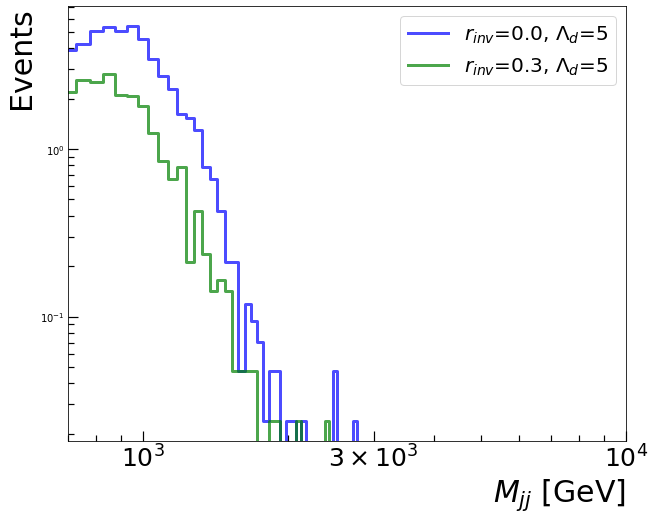

In [129]:
fig, ax = plt.subplots(1,1, figsize=(10,8)) # plotsize

weight_0_1 = Event_Weight_0_1_10[survived_list_0_1_10]/20000*37*1000
weight_03_1 = Event_Weight_03_1_10[survived_list_03_1_10]/20000*37*1000
weight_0_5 = Event_Weight_0_5_10[survived_list_0_5_10]/20000*37*1000
weight_03_5 = Event_Weight_03_5_10[survived_list_03_5_10]/20000*37*1000
weight_0_10 = Event_Weight_0_10_10[survived_list_0_10_10]/20000*37*1000
weight_03_10 = Event_Weight_03_10_10[survived_list_03_10_10]/20000*37*1000

bin_size = np.linspace(0,3000,61)


# hist_0, bins_0 = np.histogram(twojet_invariantmass_0_1_10, bins=bin_size, weights = weight_0_1)
# ax.step(bins_0[:-1], hist_0.astype(np.float32)/50, color = "c", where='mid',linewidth=3, alpha=0.7,label="$r_{inv}$=0.0, $\Lambda_d$=1") 

# hist_03, bins_03 = np.histogram(twojet_invariantmass_03_1_10, bins=bin_size, weights = weight_03_1)
# ax.step(bins_03[:-1], hist_03.astype(np.float32)/50, color = "red", where='mid',linewidth=3, alpha=0.7,label="$r_{inv}$=0.3, $\Lambda_d$=1") 


hist_0, bins_0 = np.histogram(twojet_invariantmass_0_5_10, bins=bin_size, weights = weight_0_5)
ax.step(bins_0[:-1], hist_0.astype(np.float32)/50, color = "blue", where='mid',linewidth=3, alpha=0.7,label="$r_{inv}$=0.0, $\Lambda_d$=5") 

hist_03, bins_03 = np.histogram(twojet_invariantmass_03_5_10, bins=bin_size, weights = weight_03_5)
ax.step(bins_03[:-1], hist_03.astype(np.float32)/50, color = "green", where='mid',linewidth=3, alpha=0.7,label="$r_{inv}$=0.3, $\Lambda_d$=5") 



# hist_0, bins_0 = np.histogram(twojet_invariantmass_0_10_10, bins=bin_size, weights = weight_0_10)
# ax.step(bins_0[:-1], hist_0.astype(np.float32)/50, color = "purple", where='mid',linewidth=3, alpha=0.7,label="$r_{inv}$=0.0, $\Lambda_d$=10") 

# hist_03, bins_03 = np.histogram(twojet_invariantmass_03_10_10, bins=bin_size, weights = weight_03_10)
# ax.step(bins_03[:-1], hist_03.astype(np.float32)/50, color = "orange", where='mid',linewidth=3, alpha=0.7,label="$r_{inv}$=0.3, $\Lambda_d$=10") 







plt.yscale('log') 
plt.xscale('log') 
# plt.yticks([1,100,10000],["$10^0$","$10^2$","$10^4$"], fontsize=25, rotation=0, verticalalignment='top', horizontalalignment="right")

plt.xticks([1E+3,3E+3,1E+4],["$10^3$","$3\\times10^3$","$10^4$"], fontsize=25, rotation=0, verticalalignment='top', horizontalalignment="center")

plt.tick_params(axis='x',which='minor', length=6, color='k', direction="in", width = 1.2)
plt.tick_params(axis='x',which='major', length=10, color='k', direction="in", width = 1.2)
plt.tick_params(axis='y',which='minor', length=6, color='k', direction="in", width = 1.2)
plt.tick_params(axis='y',which='major', length=10, color='k', direction="in", width = 1.2)


plt.xlim((700,10000))
plt.xlabel("$M_{jj}$ [GeV]" , fontsize=30, horizontalalignment='right',x=1)  # plot x-axis label
# plt.ylabel("d$\sigma$/d$M_{jj}$ [pb]", fontsize=30, horizontalalignment='right',y=1)  # plot y-axis label
plt.ylabel("Events", fontsize=30, horizontalalignment='right',y=1)  # plot y-axis label
# plt.xticks(fontsize=15)   # set x-ticks size
# plt.yticks(fontsize=15)   # set y-ticks size 
plt.legend(bbox_to_anchor=(1, 1),ncol=1,fontsize=20) # plot label tag
# plt.savefig("./invariant_mass_SVJ.png")  #save figure as png
plt.show()

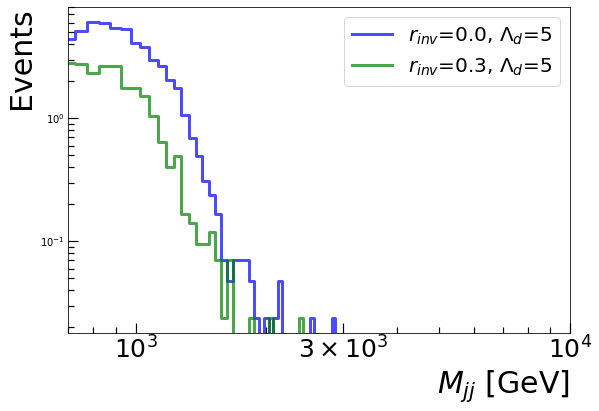

In [180]:
fig, ax = plt.subplots(1,1, figsize=(9,6)) # plotsize

weight_0_1 = Event_Weight_0_1_5[survived_list_0_1_5]/20000*37*1000#/np.sum(Event_Weight_0_1_5)
weight_03_1 = Event_Weight_03_1_5[survived_list_03_1_5]/20000*37*1000#/np.sum(Event_Weight_03_1_5)
weight_0_5 = Event_Weight_0_5_5[survived_list_0_5_5]/20000*37*1000#/np.sum(Event_Weight_0_5_5)
weight_03_5 = Event_Weight_03_5_5[survived_list_03_5_5]/20000*37*1000#/np.sum(Event_Weight_03_5_5)
weight_0_10 = Event_Weight_0_10_5[survived_list_0_10_5]/20000*37*1000#/np.sum(Event_Weight_0_10_5)
weight_03_10 = Event_Weight_03_10_5[survived_list_03_10_5]/20000*37*1000#/np.sum(Event_Weight_03_10_5)

bin_size = np.linspace(0,3000,61)


# hist_0, bins_0 = np.histogram(twojet_invariantmass_0_1_5, bins=bin_size, weights = weight_0_1)
# ax.step(bins_0[:-1], hist_0.astype(np.float32)/50, color = "c", where='mid',linewidth=3, alpha=0.7,label="$r_{inv}$=0.0, $\Lambda_d$=1") 

# hist_03, bins_03 = np.histogram(twojet_invariantmass_03_1_5, bins=bin_size, weights = weight_03_1)
# ax.step(bins_03[:-1], hist_03.astype(np.float32)/50, color = "red", where='mid',linewidth=3, alpha=0.7,label="$r_{inv}$=0.3, $\Lambda_d$=1") 


hist_0, bins_0 = np.histogram(twojet_invariantmass_0_5_5, bins=bin_size, weights = weight_0_5)
ax.step(bins_0[:-1], hist_0.astype(np.float32)/50, color = "blue", where='mid',linewidth=3, alpha=0.7,label="$r_{inv}$=0.0, $\Lambda_d$=5") 

hist_03, bins_03 = np.histogram(twojet_invariantmass_03_5_5, bins=bin_size, weights = weight_03_5)
ax.step(bins_03[:-1], hist_03.astype(np.float32)/50, color = "green", where='mid',linewidth=3, alpha=0.7,label="$r_{inv}$=0.3, $\Lambda_d$=5") 


# hist_0, bins_0 = np.histogram(twojet_invariantmass_0_10_5, bins=bin_size, weights = weight_0_10)
# ax.step(bins_0[:-1], hist_0.astype(np.float32)/50, color = "purple", where='mid',linewidth=3, alpha=0.7,label="$r_{inv}$=0.0, $\Lambda_d$=10") 

# hist_03, bins_03 = np.histogram(twojet_invariantmass_03_10_5, bins=bin_size, weights = weight_03_10)
# ax.step(bins_03[:-1], hist_03.astype(np.float32)/50, color = "orange", where='mid',linewidth=3, alpha=0.7,label="$r_{inv}$=0.3, $\Lambda_d$=10") 







plt.yscale('log') 
plt.xscale('log') 
# plt.yticks([1,100,10000],["$10^0$","$10^2$","$10^4$"], fontsize=25, rotation=0, verticalalignment='top', horizontalalignment="right")

plt.xticks([1E+3,3E+3,1E+4],["$10^3$","$3\\times10^3$","$10^4$"], fontsize=25, rotation=0, verticalalignment='top', horizontalalignment="center")

plt.tick_params(axis='x',which='minor', length=6, color='k', direction="in", width = 1.2)
plt.tick_params(axis='x',which='major', length=10, color='k', direction="in", width = 1.2)
plt.tick_params(axis='y',which='minor', length=6, color='k', direction="in", width = 1.2)
plt.tick_params(axis='y',which='major', length=10, color='k', direction="in", width = 1.2)


plt.xlim((700,10000))
plt.xlabel("$M_{jj}$ [GeV]" , fontsize=30, horizontalalignment='right',x=1)  # plot x-axis label
# plt.ylabel("d$\sigma$/d$M_{jj}$ [pb]", fontsize=30, horizontalalignment='right',y=1)  # plot y-axis label
plt.ylabel("Events", fontsize=30, horizontalalignment='right',y=1)  # plot y-axis label
# plt.xticks(fontsize=15)   # set x-ticks size
# plt.yticks(fontsize=15)   # set y-ticks size 
plt.legend(bbox_to_anchor=(1, 1),ncol=1,fontsize=20) # plot label tag
# plt.savefig("./invariant_mass_SVJ.png")  #save figure as png
plt.show()

In [71]:
twojet_invariantmass_0_10, survived_list_0_10 = Preselection(Jet_0_10)
twojet_invariantmass_03_10, survived_list_03_10 = Preselection(Jet_03_10)
# twojet_invariantmass_03, survived_list_03 = Preselection(Jet_03)
# twojet_invariantmass_05, survived_list_05 = Preselection(Jet_05)
# twojet_invariantmass_1, survived_list_1 = Preselection(Jet_1)

There are 2364 events.
There are 1124 events.


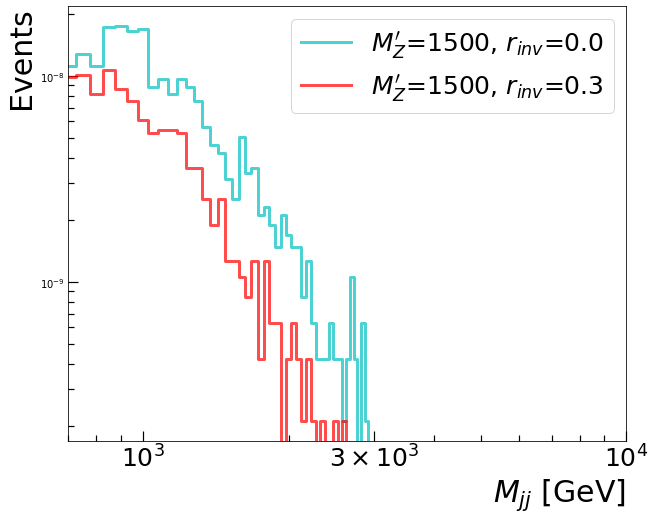

In [99]:
fig, ax = plt.subplots(1,1, figsize=(10,8)) # plotsize

weight_0 = Event_Weight_0_10[survived_list_0_10]/20000*37*1000
weight_03 = Event_Weight_03_10[survived_list_03_10]/20000*37*1000
# weight_05 = Event_Weight_05[survived_list_05]/20000*37*1000
# weight_1 = Event_Weight_1[survived_list_1]/20000*37*1000

bin_size = np.linspace(0,3000,61)


hist_0, bins_0 = np.histogram(twojet_invariantmass_0_10, bins=bin_size, weights = weight_0)
ax.step(bins_0[:-1], hist_0.astype(np.float32)/50, color = "c", where='mid',linewidth=3, alpha=0.7,label="$M_Z'$=1500, $r_{inv}$=0.0") 

hist_03, bins_03 = np.histogram(twojet_invariantmass_03_10, bins=bin_size, weights = weight_03)
ax.step(bins_03[:-1], hist_03.astype(np.float32)/50, color = "red", where='mid',linewidth=3, alpha=0.7,label="$M_Z'$=1500, $r_{inv}$=0.3") 

# hist_05, bins_05 = np.histogram(twojet_invariantmass_05, bins=bin_size, weights = weight_05)
# plt.step(bins_05[:-1], hist_05.astype(np.float32)/50, color = "blue", where='mid',linewidth=3, alpha=0.7,label="$M_Z$=1500, $r_{inv}$=0.5") 

# hist_1, bins_1 = np.histogram(twojet_invariantmass_1, bins=bin_size, weights = weight_1)
# plt.step(bins_1[:-1], hist_1.astype(np.float32)/50, color = "magenta", where='mid',linewidth=3, alpha=0.7,label="$M_Z$=1500, $r_{inv}$=1.0") 


plt.yscale('log') 
plt.xscale('log') 
# plt.yticks([1,100,10000],["$10^0$","$10^2$","$10^4$"], fontsize=25, rotation=0, verticalalignment='top', horizontalalignment="right")

plt.xticks([1E+3,3E+3,1E+4],["$10^3$","$3\\times10^3$","$10^4$"], fontsize=25, rotation=0, verticalalignment='top', horizontalalignment="center")

plt.tick_params(axis='x',which='minor', length=6, color='k', direction="in", width = 1.2)
plt.tick_params(axis='x',which='major', length=10, color='k', direction="in", width = 1.2)
plt.tick_params(axis='y',which='minor', length=6, color='k', direction="in", width = 1.2)
plt.tick_params(axis='y',which='major', length=10, color='k', direction="in", width = 1.2)


plt.xlim((700,10000))
plt.xlabel("$M_{jj}$ [GeV]" , fontsize=30, horizontalalignment='right',x=1)  # plot x-axis label
# plt.ylabel("d$\sigma$/d$M_{jj}$ [pb]", fontsize=30, horizontalalignment='right',y=1)  # plot y-axis label
plt.ylabel("Events", fontsize=30, horizontalalignment='right',y=1)  # plot y-axis label
# plt.xticks(fontsize=15)   # set x-ticks size
# plt.yticks(fontsize=15)   # set y-ticks size 
plt.legend(bbox_to_anchor=(1, 1),ncol=1,fontsize=25) # plot label tag
# plt.savefig("./invariant_mass_SVJ.png")  #save figure as png
plt.show()

In [56]:
m_dxdx = Find_xdxd(GenParticle_03_10)

total events: 4769 


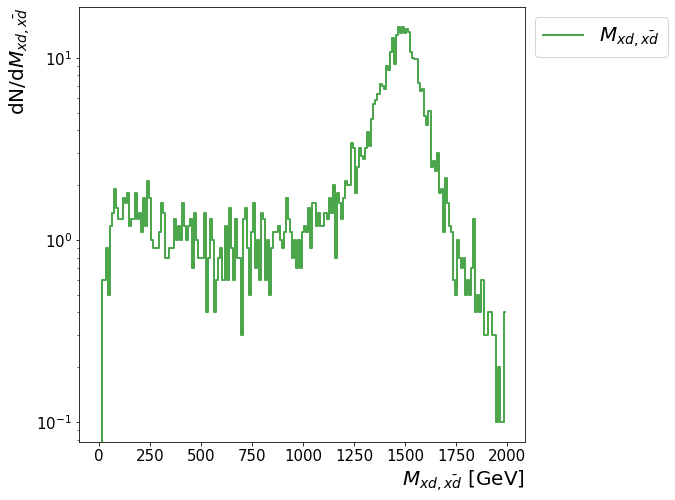

In [60]:
plt.figure(figsize=(8,8)) # plotsize

print("total events: {} ".format(len(m_dxdx)))

bin_size = np.linspace(0,2000,201)
hist, bins = np.histogram(m_dxdx, bins=bin_size)
plt.step(bins[:-1], hist.astype(np.float32)/10,color = "green", where='mid',linewidth=2, alpha=0.7,label="$M_{xd,\\bar{xd}}$") 

plt.legend(bbox_to_anchor=(1, 1),ncol=2,fontsize=20) # plot label tag
plt.yscale('log') 
plt.xlabel("$M_{xd,\\bar{xd}}$ [GeV]" , fontsize=20, horizontalalignment='right',x=1)  # plot x-axis label
plt.ylabel("dN/d$M_{xd,\\bar{xd}}$", fontsize=20, horizontalalignment='right',y=1)  # plot y-axis label
plt.xticks(fontsize=15)   # set x-ticks size
plt.yticks(fontsize=15)   # set y-ticks size 
# plt.savefig("./invariant_mass_SVJ.png")  #save figure as png
plt.show()

In [102]:
aaa = [1,5,10,50,100,150,200,250,300,350]
# print(aaa)
for i, lambda_d in enumerate(aaa):
    print("lambda: {:^7.3f}  alpha:{:^7.3f}".format(aaa[i],np.pi*2/((11./3.*2-2./3.*2)*np.log(1000./lambda_d))))


lambda:  1.000   alpha: 0.152 
lambda:  5.000   alpha: 0.198 
lambda: 10.000   alpha: 0.227 
lambda: 50.000   alpha: 0.350 
lambda: 100.000  alpha: 0.455 
lambda: 150.000  alpha: 0.552 
lambda: 200.000  alpha: 0.651 
lambda: 250.000  alpha: 0.755 
lambda: 300.000  alpha: 0.870 
lambda: 350.000  alpha: 0.997 


In [62]:
class BrachGenParticles:
    def __init__(self,file):
        self.file = file
        self.Status = file["Particle.Status"].array()
        self.PID = file["Particle.PID"].array()
        self.M1 = file["Particle.M1"].array()
        self.M2 = file["Particle.M2"].array()
        self.D1 = file["Particle.D1"].array()
        self.D2  = file["Particle.D2"].array()
        self.PT = file["Particle.PT"].array()
        self.Eta =  file["Particle.Eta"].array()
        self.Phi = file["Particle.Phi"].array()
        self.Mass = file["Particle.Mass"].array()
        self.Labels = ["Status", "PID" , "M1", "M2", "D1", "D2", "PT", "Eta", "Phi", "Mass"]
        
    def Status_At(self, i):
        return self.Status[i]
    def PID_At(self, i):
        return self.PID[i]
    def M1_At(self, i):
        return self.M1[i]
    def M2_At(self, i):
        return self.M2[i]
    def D1_At(self, i):
        return self.D1[i]
    def D2_At(self, i):
        return self.D2[i]
    def PT_At(self, i):
        return self.PT[i]
    def Eta_At(self, i):
        return self.Eta[i]
    def Phi_At(self, i):
        return self.Phi[i]
    def Mass_At(self, i):
        return self.Mass[i]

In [63]:
filepath_03_10 = "/home/Storage/MG5_Study_Group/ROOT/Scan_rinv_alpha_md50/SVJ_3_10.root"
file_03_10 = uproot.open(filepath_03_10)["Delphes;1"]

aaa = BrachGenParticles(file_03_10)



In [64]:
len(aaa.Status_At(8)) #- 
# len(aaa.D1_At(8))

555

In [515]:
aaa.At(3)



In [529]:
aaa.At(6)
aaa.Status

array([ 4,  4, 21, ...,  1,  1,  1], dtype=int32)

In [ ]:
def M(pt1,eta1,phi1,m1,pt2,eta2,phi2,m2):
    px1, py1, pz1 = pt1*np.cos(phi1), pt1*np.sin(phi1), np.sqrt(m1**2+pt1**2)*np.sinh(eta1)
    e1 = np.sqrt(m1**2 + px1**2 + py1**2 + pz1**2)
    px2, py2, pz2 = pt2*np.cos(phi2), pt2*np.sin(phi2), np.sqrt(m2**2+pt2**2)*np.sinh(eta2)
    e2 = np.sqrt(m2**2 + px2**2 + py2**2 + pz2**2)
    
    return np.sqrt((e1+e2)**2-(px1+px2)**2-(py1+py2)**2-(pz1+pz2)**2)

In [ ]:
 4    23   4900101   2      3      8      8    295.43 -0.464870.32415   10.0  
  5    23   -4900101   2      3      6      7    295.43 -2.2828 -2.8174   10.0  

In [38]:
M(295.43,-0.46487,0.32415,10.0,295.43,-2.2828,-2.8174,10.0)

852.7131222865531